<a href="https://colab.research.google.com/github/hetu2002/QCCNN/blob/main/newipython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新段落

In [1]:
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 16.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

import pandas as pd

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
import csv
with open('/content/sample_data/tetris_dataset.csv', 'r') as csvfile:
    so = csv.reader(csvfile, delimiter=',', quotechar='"')
    so_data = []
    for row in so:
      so_data.append(row)

    # print(so_data[1][1:])

x_train = []
y_train = []

a = 1
b = 1
while a < 1001:
  while b < 10:
    x_train.append(so_data[a][b])
    b = b + 1
  a = a + 1
  b = 1

c = 1
while c<1001:
  y_train.append(so_data[c][0])
  c = c + 1

x_train = np.asarray(x_train).astype("float64")

x_train_bin = np.reshape(x_train, (1000,9))
y_train = np.reshape(y_train, (1000, 1))
x_test_bin = x_train_bin
y_test = y_train

print(x_test_bin)

[[0.94868902 0.76242304 0.7062115  ... 0.09444752 0.08848991 0.94834388]
 [0.03998312 0.0481388  0.93863499 ... 0.70477111 0.81424792 0.91297874]
 [0.8552594  0.83890838 0.89158966 ... 0.02601557 0.03400646 0.86586322]
 ...
 [0.9400824  0.05059959 0.90070851 ... 0.70145528 0.0580354  0.77006243]
 [0.8883635  0.00662    0.87148989 ... 0.76382981 0.94520178 0.76203999]
 [0.89184559 0.02137074 0.71740101 ... 0.86079717 0.89770764 0.78282552]]


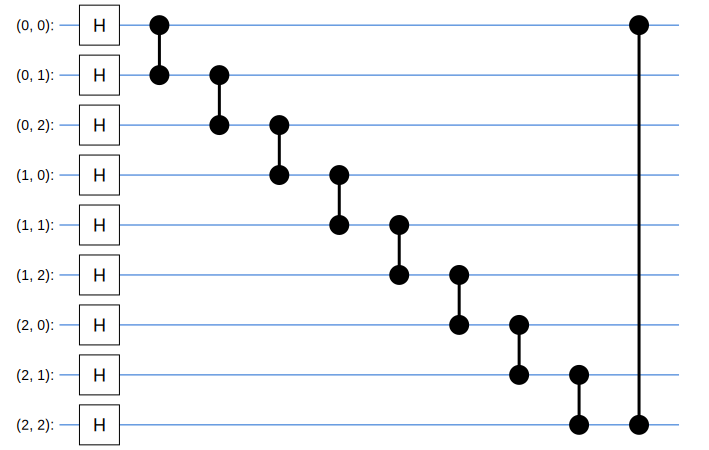

In [5]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

cluster_state_bits = cluster_state_circuit(cirq.GridQubit.rect(3, 3))

SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(3, 3)))


In [6]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(3, 3)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

# convert data to circuit 
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# convert data to tensor format 
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

print(x_train_tfcirc.shape , x_test_tfcirc.shape)

(1000,) (1000,)


In [7]:
bin_img = x_train_bin[:,:]
indices = np.array(np.where(bin_img)).T

# change data target to 1 or -1 
y_train_hinge = y_train
y_test_hinge = y_test

print(y_train_hinge.shape, y_test_hinge.shape)

(1000, 1) (1000, 1)


In [8]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])
    

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [9]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit
  
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit


class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

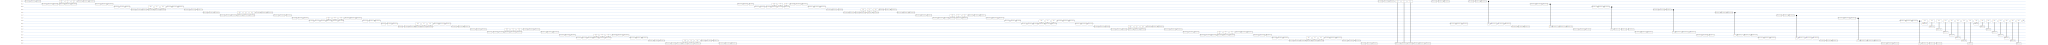

In [10]:
qubits = cirq.GridQubit.rect(4, 4)
readout = cirq.GridQubit(1,2)
circuit = cirq.Circuit()


symbols = sympy.symbols('qconv0:84')
circuit += quantum_conv_circuit(qubits , symbols[0:15]) # range symbols always 16
circuit += quantum_pool_circuit(qubits[:8], qubits[8:], symbols[15:21])


readout_qnn = cirq.GridQubit(1, 3)
data_qubits_qnn = cirq.GridQubit.rect(4, 4)[8:]

builder = CircuitLayerBuilder( data_qubits = data_qubits_qnn, readout=readout_qnn)

# Then add layers (experiment by adding more).
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")

model_readout = circuit.append(cirq.H(cirq.GridQubit(1, 3)))

SVGCircuit(circuit)

In [11]:
readout_operators = cirq.Z(qubits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(qubits))

quantum_model = tfq.layers.PQC(circuit,
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

In [12]:
print(len(y_train_hinge), x_train_tfcirc.shape)
print(len(y_test_hinge), x_test_tfcirc.shape)

EPOCH = 5
BATCH_SIZE = 32

NUM_EXAMPLES = 500
#NUM_EXAMPLES = len(x_train_tfcirc)

NUM_EXAMPLES

1000 (1000,)
1000 (1000,)


500

In [14]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
print(x_train_tfcirc_sub.shape , y_train_hinge_sub.shape)
y_train_hinge_sub = [tuple(row) for row in y_train_hinge_sub]
collections.Counter(y_train_hinge_sub)

(500,) (500, 1)


Counter({('S',): 250, ('L',): 250})

In [15]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[hinge_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc_sub,
                         y=y_train_hinge_sub,
                         batch_size=16,
                         epochs=EPOCH,
                         verbose=1,
                         validation_data=(x_test_tfcirc , y_test_hinge))

IndexError: ignored

In [16]:
import pandas as pd
df_history = pd.DataFrame()
df_history['accuracy']  = history.history['hinge_accuracy']
df_history['loss']      = history.history['loss']
df_history['val_accuracy'] = history.history['val_hinge_accuracy']
df_history['val_loss']  = history.history['val_loss']

df_history.to_csv("history.csv", index = False)

print(df_history.shape)
df_history.head()

NameError: ignored